# Conociendo $R_t$

$R_t$ es conocido como la medida de reproducción efectiva: cantidad de personas que se infectan por persona infectada en el tiempo $t$

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
# Vector columna k
k = np.arange(0, 70)[:, None]

In [3]:
# Valores para lambda
lambdas = [10, 20, 30, 40]

In [5]:
# Evaluando la pmf (poisson es discreto)
y = sps.poisson.pmf(k, lambdas)
y.shape

(70, 4)

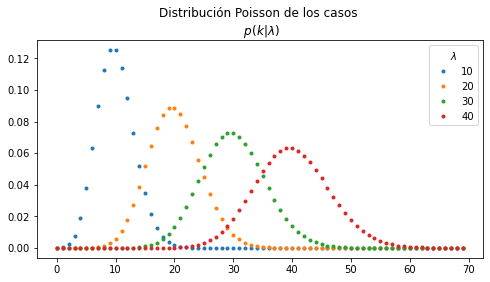

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set(title='Distribución Poisson de los casos \n $p(k|\lambda)$')
ax.plot(k,y,
         marker='o',
         markersize=3,
         lw=0)
ax.legend(title="$\lambda$", labels=lambdas);

La distribución Poisson nos indica que si creemos tener $k$ casos en un día, es probable que tengamos esa cantidad más o menos alguna variación.

Sin embargo, en este caso nosotros sabremos la cantidad de casos que hubieron($k$) y lo que necesitaremos conocer es el valor de $\lambda$ que lo satisface.

Para realizar esto, fijaremos el valor de $k$ mientras variamos $\lambda$, generando una **función probabilística**

Aquí un ejemplo: teniendo que $k = 30$ casos nuevos, deseamos saber qué tan probable es cada valor de  $\lambda$ 

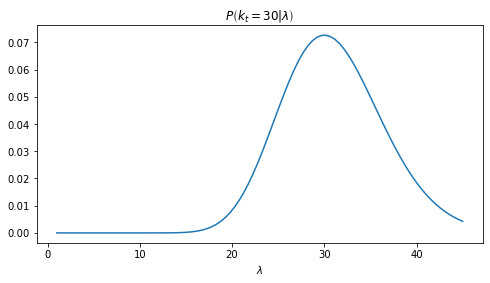

In [15]:
k = 30

_lambda = np.linspace(1, 45, 90)
likelihood = pd.Series(data=sps.poisson.pmf(k, _lambda),
                       index=pd.Index(_lambda, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'$P\left(k_t=30|\lambda\right)$', figsize=(8,4));

Si vemos 30 casos, el valor más probable que puede tomar $\lambda$ es 30. Pero no estamos seguros: es posible que $\lambda$ tomara el valor de 21 o 17 y vio 20 casos nuevos solo "por casualidad". También dice que es poco probable que $\lambda$ tuviera 40 y vimos 20.

### Conectando $\lambda$ y $R_t$

__El punto clave es establecer la relación entre $R_t$ y $\lambda$__. 

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

donde $\gamma$ será el inverso del tamaño del intervalo de serie ([7 días para COVID-19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)).

Conocemos la cantidad de casos que hubo un día anterior, por ende podemosreformular la función de probabilidad como una función de Poisson parametrizada por fijar $k$ y variar $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

Imaginemos una muestra de nuevos casos $k$. ¿Cuál es la probabilidad de diferentes valores de $R_t$ para cada uno de esos días?

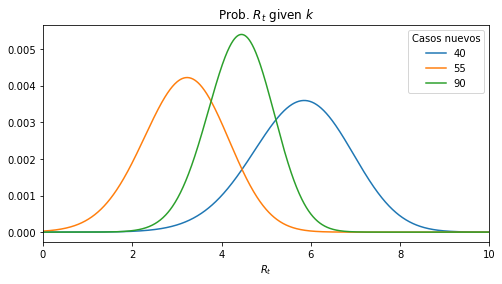

In [25]:
k = np.array([20, 40, 55, 90])

# Creamos un array para los posibles valores de Rt
maxRt = 12
rangeRt = np.linspace(0, maxRt, maxRt*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Mapeando Rt en lambda y sustituimos en la ecuación que definimos anteriormente
lam = k[:-1] * np.exp(GAMMA * (rangeRt[:, None] - 1))
# Tenemos n-1 lambdas, debido a que el primer día no tenemos valor anterior

# Evaluamos la probabilidad de cada día y estandarizamos
likelihoodRt = sps.poisson.pmf(k[1:], lam)
likelihoodRt /= np.sum(likelihoodRt, axis=0)

# Plot it
ax = pd.DataFrame(data = likelihoodRt,index = rangeRt)\
       .plot(title='Prob. $R_t$ given $k$',
            xlim=(0,10),
            figsize=(8,4))

ax.legend(labels=k[1:], title='Casos nuevos')
ax.set_xlabel('$R_t$');

Cada día tenemos conjeturas independientes para Rt. El objetivo es combinar la información que obtuvimos sobre los días anteriores y usarla con el día actual. 
Para hacer esto, usamos el teorema de Bayes.

Necesitamos multiplicar la probabilidad a priori(día previo sin actualización Gaussiana) para obtener los posteriores.Usaremos el producto acumulado de cada día.   

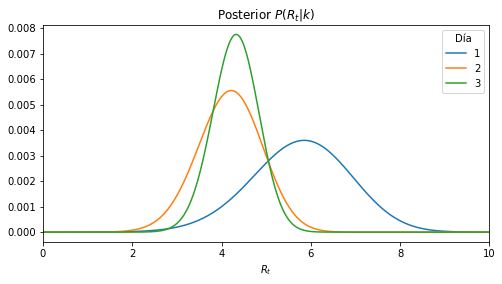

In [27]:
posteriors = likelihoodRt.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), 
                   name='day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = rangeRt,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(8,4)
)
ax.legend(title='Día')
ax.set_xlabel('$R_t$');

- El posterior del día 1 coincide con la prob. del día 1 debido a que no tenemos suficiente información de ese día
- Cuando usamos la información del día 2, la curva se mueve ligeramente a la izquierda, pero no de igual forma que la curva anterior, debido a que la actualización bayesiana utiliza información de ambos días y las promedia.
- El día 3 se ecnuentra entre los otros dos, con un pequeño cambio hacia la derecha. Algo importante: se observa una distribución más estrecha.

In [28]:
mostLikelyValues = posteriors.idxmax(axis=0)
mostLikelyValues

day
1    5.85
2    4.22
3    4.33
dtype: float64

También podemos obtener los intervalos de más alta densidad para Rt:

In [33]:
def highest_density_interval(pmf, p=.9, debug=False):
    # Cuando pasemos un dataframe, se iterará recursivamente sobre las columnas
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    #Matriz NxN de cmf para cada valor alto y bajo
    pTotal = cumsum - cumsum[:, None]
    
    # Indices con pTotal > p
    lows, highs = (pTotal > p).nonzero()
    
    # Encuentre el más pequeño rango de valores (Densidad más alta)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'low{p*100:.0f}',
                            f'high{p*100:.0f}'])

In [34]:
hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

,low90,high90
day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


Finalmente, podemos graficar los valores más probables para $R_t$ y los HDIs en el tiempo, mostrándonos cómo varía su comportamiento día a día

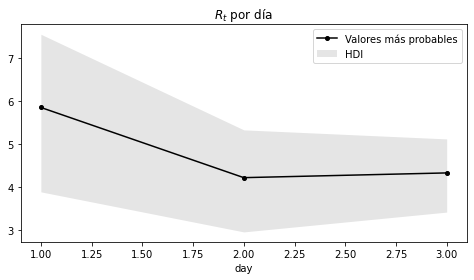

In [38]:
ax = mostLikelyValues.plot(marker='o',
                           label='Valores más probables',
                           title=f'$R_t$ por día',
                           c='k',
                           markersize=4,
                           figsize = (8,4))

ax.fill_between(hdi.index,
                hdi['low90'],
                hdi['high90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

Vemos que el valor de $R_t$ varía en el tiempo, y el HDI se vuelve más estrecho debido a que vamos conociendo más el valor de $R_t$ a medida que el tiempo avanza.